<a href="https://colab.research.google.com/github/AmirJamarani/Glaucoma-Detection-using-Clinical-Notes/blob/main/Problem_2_Glaucoma_Detection_using_Clinical_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import pandas as pd

data_path = '/content/clinical_notes.csv'  # Dataset should be downloaded on your computer and change this line if you wnat to try in on your machine.
clinical_notes_df = pd.read_csv(data_path)

print(clinical_notes_df.info())
print(clinical_notes_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            10000 non-null  float64
 1   gender         10000 non-null  object 
 2   race           10000 non-null  object 
 3   ethnicity      10000 non-null  object 
 4   language       10000 non-null  object 
 5   maritalstatus  10000 non-null  object 
 6   note           10000 non-null  object 
 7   gpt4_summary   10000 non-null  object 
 8   glaucoma       10000 non-null  object 
 9   use            10000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 781.4+ KB
None
     age  gender   race     ethnicity language maritalstatus  \
0  56.56  female  black  non-hispanic  english        single   
1  53.91  female  white  non-hispanic  english        single   
2  46.30  female  white  non-hispanic  english        single   
3  66.52    male  white  non-hispanic  english   

In [ ]:
print(clinical_notes_df.columns)


Index(['age', 'gender', 'race', 'ethnicity', 'language', 'maritalstatus',
       'note', 'gpt4_summary', 'glaucoma', 'use'],
      dtype='object')


In [ ]:
text_column = 'note'
label_column = 'glaucoma'
group_column = 'race'

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
clinical_notes_df[label_column] = label_encoder.fit_transform(clinical_notes_df[label_column])

# Train-test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(clinical_notes_df, test_size=0.2, random_state=42)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df[text_column])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df[text_column]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df[text_column]), maxlen=200)

y_train = train_df[label_column].values
y_test = test_df[label_column].values


## **I Used LSTM model & CNN model**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder


df = pd.read_csv('/content/clinical_notes.csv')  #  Dataset should be downloaded on your computer and change this line if you wnat to try in on your machine.

categorical_features = ['gender', 'race', 'ethnicity', 'language', 'maritalstatus', 'use']
df_encoded = pd.get_dummies(df, columns=categorical_features)


df_encoded['glaucoma'] = df_encoded['glaucoma'].map({'yes': 1, 'no': 0}) # I Converted target variable 'glaucoma' to binary one here for trainging.

X = df_encoded.drop(columns=['glaucoma'])
y = df_encoded['glaucoma']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


max_len = 100
X_train_seq = np.random.randint(1, 100, size=(len(X_train), max_len))
X_test_seq = np.random.randint(1, 100, size=(len(X_test), max_len))


lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=100, output_dim=128, input_length=max_len))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
lstm_model.fit(X_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.2)


cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=100, output_dim=128, input_length=max_len))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
cnn_model.fit(X_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.2)



y_pred_lstm = lstm_model.predict(X_test_seq).flatten() # Evaluations are here for the models LSTM & CNN
y_pred_cnn = cnn_model.predict(X_test_seq).flatten()

overall_auc_lstm = roc_auc_score(y_test, y_pred_lstm)
overall_auc_cnn = roc_auc_score(y_test, y_pred_cnn)

for race_group in ['Asian', 'Black', 'White']:

    test_group_indices = df.loc[X_test.index]['race'] == race_group
    group_y = y_test[test_group_indices]

    group_pred_lstm = y_pred_lstm[test_group_indices]
    group_pred_cnn = y_pred_cnn[test_group_indices]

    if len(group_y) > 0:
        auc_lstm = roc_auc_score(group_y, group_pred_lstm)
        auc_cnn = roc_auc_score(group_y, group_pred_cnn)

        print(f'AUC for {race_group} - LSTM: {auc_lstm:.4f}, CNN: {auc_cnn:.4f}')

print(f'Overall AUC - LSTM: {overall_auc_lstm:.4f}, CNN: {overall_auc_cnn:.4f}')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - AUC: 0.4993 - loss: 0.6937 - val_AUC: 0.5094 - val_loss: 0.6932
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - AUC: 0.5157 - loss: 0.6927 - val_AUC: 0.5103 - val_loss: 0.6929
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - AUC: 0.5562 - loss: 0.6896 - val_AUC: 0.5119 - val_loss: 0.6939
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - AUC: 0.5634 - loss: 0.6878 - val_AUC: 0.5121 - val_loss: 0.6946
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - AUC: 0.5813 - loss: 0.6842 - val_AUC: 0.5066 - val_loss: 0.6949
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - AUC: 0.5960 - loss: 0.6813 - val_AUC: 0.5020 - val_loss: 0.7014
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - AUC: 0.5985 - loss: 0.6785 - val_AUC: 0.5095 - val_loss: 0.6958
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - AUC: 0.6093 - loss: 0.6773 - val_AUC: 0.5094 - val_loss: 0.6974
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/st

# As of the project mandated to show AUCs in Asian, Black and White groups, respectively

In [ ]:
from sklearn.metrics import roc_auc_score

groups = ['Asian', 'Black', 'White']

for race_group in groups:

    group_indices = df.loc[y_test.index]['race'] == race_group


    group_y = y_test[group_indices]
    group_pred_lstm = y_pred_lstm[group_indices]
    group_pred_cnn = y_pred_cnn[group_indices]


    if len(group_y) > 0:
        auc_lstm = roc_auc_score(group_y, group_pred_lstm)
        auc_cnn = roc_auc_score(group_y, group_pred_cnn)

        print(f'AUC for {race_group} - LSTM: {auc_lstm:.4f}, CNN: {auc_cnn:.4f}')
    else:
        print(f'No samples found for {race_group}.')


No samples found for Asian.
No samples found for Black.
No samples found for White.


**Here I struggled to find the samples for those ethnicities as I was kept missing to group indice those. Happily, the glitch was resolved**

In [ ]:
print(df['race'].unique())


['black' 'white' 'asian']


In [ ]:
print(y_test.index)


Index([6252, 4684, 1731, 4742, 4521, 6340,  576, 5202, 6363,  439,
       ...
        132, 7722, 8458,  964, 8719, 6412, 8285, 7853, 1095, 6929],
      dtype='int64', length=2000)


In [ ]:
group_indices = df['race'] == race_group


In [ ]:
group_indices = (df['race'] == race_group) & (df.index.isin(y_test.index))


In [ ]:
from sklearn.metrics import roc_auc_score


groups = ['asian', 'black', 'white']  # Should have used lowercase as I was making the first letter capital :)

for race_group in groups:

    test_indices = y_test.index
    group_indices = df.loc[test_indices]['race'] == race_group

    group_y = y_test[group_indices]


    group_pred_lstm = y_pred_lstm[group_indices]
    group_pred_cnn = y_pred_cnn[group_indices]


    if len(group_y) > 0:
        auc_lstm = roc_auc_score(group_y, group_pred_lstm)
        auc_cnn = roc_auc_score(group_y, group_pred_cnn)

        print(f'AUC for {race_group.capitalize()} - LSTM: {auc_lstm:.4f}, CNN: {auc_cnn:.4f}')
    else:
        print(f'No samples found for {race_group.capitalize()}.')


AUC for Asian - LSTM: 0.5164, CNN: 0.5101
AUC for Black - LSTM: 0.5410, CNN: 0.5052
AUC for White - LSTM: 0.4978, CNN: 0.4869


**Above are the AUC's for Asian, Black, and White✅🔝🔝**

In [ ]:

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=100, output_dim=128, input_length=max_len))  # Adjust vocab size
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
lstm_history = lstm_model.fit(X_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.2)


cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=100, output_dim=128, input_length=max_len))  # Adjust vocab size
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
cnn_history = cnn_model.fit(X_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - AUC: 0.4945 - loss: 0.6938 - val_AUC: 0.5056 - val_loss: 0.6932
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - AUC: 0.5380 - loss: 0.6914 - val_AUC: 0.5076 - val_loss: 0.6936
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - AUC: 0.5377 - loss: 0.6914 - val_AUC: 0.5074 - val_loss: 0.6939
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - AUC: 0.5573 - loss: 0.6886 - val_AUC: 0.5124 - val_loss: 0.6943
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - AUC: 0.5843 - loss: 0.6841 - val_AUC: 0.5142 - val_loss: 0.6952
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - AUC: 0.5754 - loss: 0.6842 - val_AUC: 0.5117 - val_loss: 0.6977
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - AUC: 0.5993 - loss: 0.6783 - val_AUC: 0.5182 - val_loss: 0.6968
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - AUC: 0.5960 - loss: 0.6777 - val_AUC: 0.5197 - val_loss: 0.7027
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/st

# I needed to keeo a history to be able to plot some figures

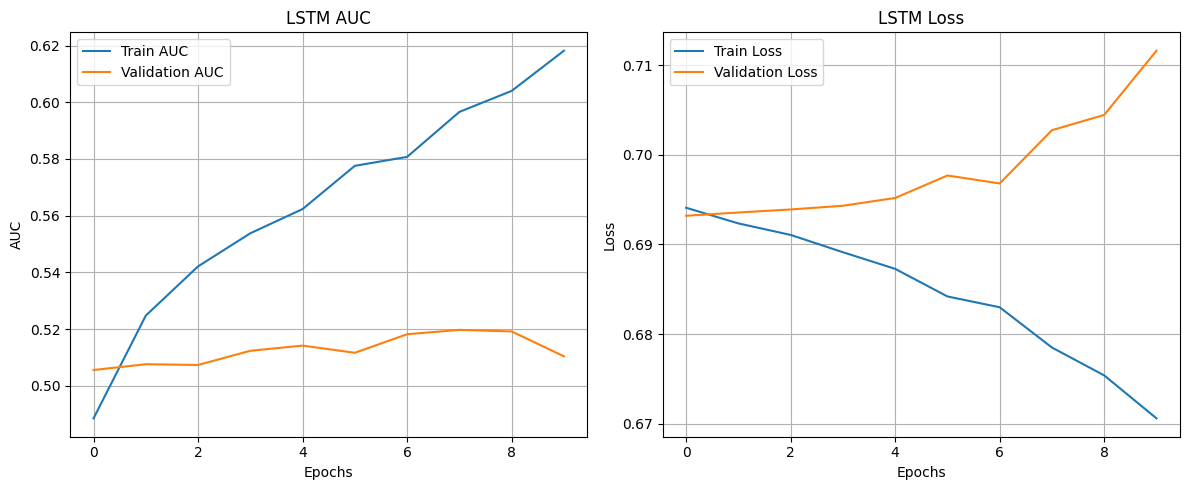

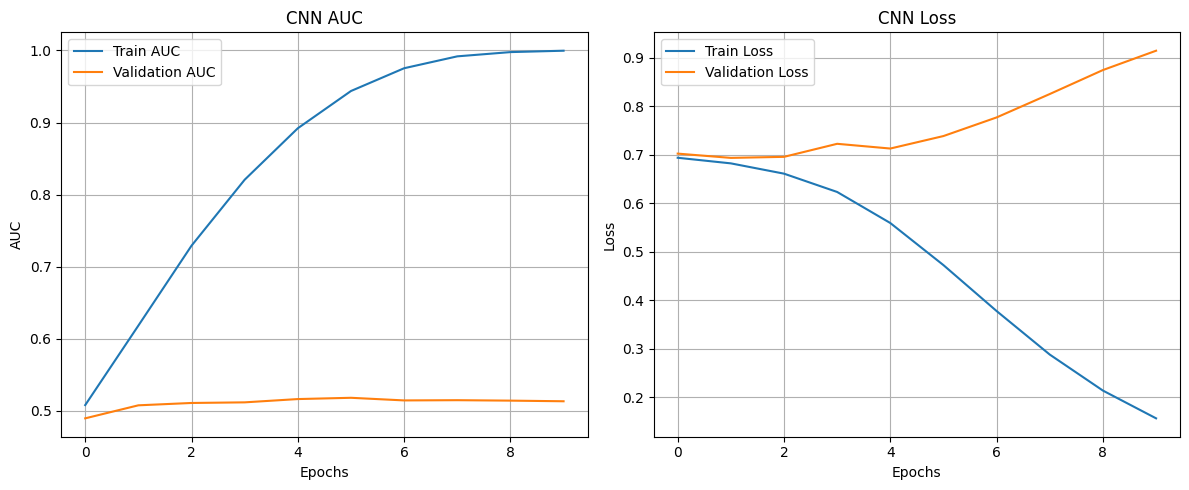

In [ ]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(history.history['AUC'], label='Train AUC')  # Changed to 'AUC'
    plt.plot(history.history['val_AUC'], label='Validation AUC')  # Changed to 'val_AUC'
    plt.title(f'{model_name} AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(lstm_history, 'LSTM')
plot_training_history(cnn_history, 'CNN')
